In [1]:
############################
##### LOAD LIBRARIES #######
############################

import os
import rasterio
from rasterio.windows import Window
import pandas as pd
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import xml.etree.ElementTree as ET

In [4]:
############################
###### LOCATION SPECS ######
############################

path = 170
row_name = '064'
path_row = "170064"
wd = "D:/"
location = "nn"
qual_folder = os.path.join(wd, f'{path}_{row_name}_qual')
trim_folder = os.path.join(wd, f'trimmed_{path}_{row_name}')
raw_folder = os.path.join(wd, f'{path}_{row_name}_raw')
csv_folder = os.path.join(wd, f"{path}_{row_name}_select_csv")
os.makedirs(csv_folder, exist_ok=True)

In [63]:
###########################
###### CSV FUNCTIONS ######
###########################
def extract_utm_zone(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    zone_tag = root.find('.//{http://espa.cr.usgs.gov/v2}zone_code')

    if zone_tag is not None:
        zone_code = zone_tag.text.strip()
        return zone_code
    else:
        return None

def utm_to_latlon(row, east_name, north_name, zone_number):
    easting = row[east_name]
    northing = row[north_name]

    utm_proj = Proj(proj='utm', zone=zone_number, ellps='WGS84', datum='WGS84')

    lon, lat = utm_proj(easting, northing, inverse=True)

    return pd.Series({'lat': lat, 'lon': lon})

def raster_to_csv(raster_file_sow, quality_file_sow,
                  raster_file_gro, quality_file_gro,
                  #east_name, north_name, zone_number,
                  output_joined, evi_name_sow, qual_name_sow, evi_name_gro, qual_name_gro):

    with rasterio.open(raster_file_sow) as src:
        raster_array = src.read(1)
        nodata_value = src.nodata
        raster_array = np.where(raster_array == nodata_value, np.nan, raster_array)
        transform = src.transform

        rows, cols = raster_array.shape
        X_s, Y_s = np.meshgrid(np.arange(0, cols), np.arange(0, rows))
        east_s, north_s = transform * (X_s, Y_s)

        flat_east_s = east_s.flatten()
        flat_north_s = north_s.flatten()
        flat_data_s = raster_array.flatten()

        evi = pd.DataFrame({
            'easting': flat_east_s,
            'northing': flat_north_s,
            evi_name_sow : flat_data_s
        })
    with rasterio.open(quality_file_sow) as src:
        quality_array = src.read(1)
        nodata_value = src.nodata
        quality_array = np.where(quality_array == nodata_value, np.nan, quality_array)
        transform = src.transform
        rows, cols = quality_array.shape
        X_q_s, Y_q_s = np.meshgrid(np.arange(0, cols), np.arange(0, rows))

        east_q_s, north_q_s = transform * (X_q_s, Y_q_s)

        flat_east_q_s = east_q_s.flatten()
        flat_north_q_s = north_q_s.flatten()
        flat_data_q_s = quality_array.flatten()

        qual = pd.DataFrame({
            'easting': flat_east_q_s,
            'northing': flat_north_q_s,
            qual_name_sow : flat_data_q_s
        })
    with rasterio.open(raster_file_gro) as src:
        raster_array = src.read(1)
        nodata_value = src.nodata
        raster_array = np.where(raster_array == nodata_value, np.nan, raster_array)
        transform = src.transform

        rows, cols = raster_array.shape
        X_g, Y_g = np.meshgrid(np.arange(0, cols), np.arange(0, rows))
        east_g, north_g = transform * (X_g, Y_g)

        flat_east_g = east_g.flatten()
        flat_north_g = north_g.flatten()
        flat_data_g = raster_array.flatten()

        evi_g = pd.DataFrame({
            'easting': flat_east_g,
            'northing': flat_north_g,
            evi_name_gro : flat_data_g
        })
    with rasterio.open(quality_file_gro) as src:
        quality_array = src.read(1)
        nodata_value = src.nodata
        quality_array = np.where(quality_array == nodata_value, np.nan, quality_array)
        transform = src.transform
        rows, cols = quality_array.shape
        X_q_g, Y_q_g = np.meshgrid(np.arange(0, cols), np.arange(0, rows))

        east_q_g, north_q_g = transform * (X_q_g, Y_q_g)

        flat_east_q_g = east_q_g.flatten()
        flat_north_q_g = north_q_g.flatten()
        flat_data_q_g = quality_array.flatten()

        qual_g = pd.DataFrame({
            'easting': flat_east_q_g,
            'northing': flat_north_q_g,
            qual_name_gro : flat_data_q_g
        })

    #df = pd.merge(evi, qual, evi_g, qual_g, on=['easting', 'northing'])
    df = pd.merge(evi, qual, on=['easting', 'northing'])
    df1 = pd.merge(df, evi_g, on=['easting', 'northing'])
    df2 = pd.merge(df1, qual_g, on=['easting', 'northing'])
    #
    # del evi
    # del qual
    # del qual_g
    # del evi_g

    #df[['latitude', 'longitude']] = df.apply(utm_to_latlon, axis=1, args=(east_name, north_name, zone_number))

    output_file = os.path.join(output_joined,os.path.basename(raster_file_sow)[17:25] + os.path.basename(raster_file_gro)[16:25] + f'_{path}_{row_name}_{location}.csv')
    df2.to_csv(output_file, index=False)
pass

In [40]:
################################
###### ORGANIZE TIF FILES ######
################################

with open(f"{qual_folder}/{path}_{row_name}_{location}_bounded_scenes.txt", "r") as file:
    alls_1 = file.readlines()

with open(f"{qual_folder}/{path}_{row_name}_{location}_evi_scenes.txt", "r") as file:
    evis_1 = file.readlines()

with open(f"{qual_folder}/{path}_{row_name}_{location}_quality_scenes.txt", "r") as file:
    quals_1 = file.readlines()

alls = [all.strip() for all in alls_1]
evis = [evi.strip() for evi in evis_1]
quals = [qual.strip() for qual in quals_1]

starting_year = 1984
ending_year = 2023
years = range(starting_year, ending_year + 1)
file_df = pd.DataFrame(columns=['evi_sow','evi_gro', 'qual_sow','qual_gro','xml'], index=years)
csv_folder = os.path.join(wd, f"{path}_{row_name}_select_csv")
os.makedirs(csv_folder, exist_ok=True)

for entry in evis:
    year = int(entry[17:21])
    season = entry[48:51]
    file_name = os.path.join(trim_folder, entry)
    if year in file_df.index and season == 'sow':
        file_df.at[year, 'evi_sow'] = os.path.join(trim_folder, entry)
    elif year in file_df.index and season == 'gro':
        file_df.at[year, 'evi_gro'] = os.path.join(trim_folder, entry)
    else:
        continue
    base = entry[0:40]
    file_df.at[year, 'xml'] = os.path.join(raw_folder,f'{base}.xml')

for entry in quals:
    year = int(entry[17:21])
    season = entry[50:53]
    file_name = os.path.join(trim_folder, entry)
    if year in file_df.index and season == 'sow':
        file_df.at[year, 'qual_sow'] = os.path.join(trim_folder, entry)
    elif year in file_df.index and season == 'gro':
        file_df.at[year, 'qual_gro'] = os.path.join(trim_folder, entry)
    else:
        continue

In [64]:
##########################################
## CONVERT TO CSVS & MERGE BY QUAL, EVI ##
##########################################

for index, row in file_df.iterrows():
    if pd.isna(row['evi_gro']):
        continue
    else:
        raster_file_sow = row['evi_sow']
        quality_file_sow = row['qual_sow']
        raster_file_gro = row['evi_gro']
        quality_file_gro = row['qual_gro']
        xml_file = row['xml']
        print(xml_file)
        #zone_number = extract_utm_zone(xml_file)
        year = index
        raster_to_csv(raster_file_sow, quality_file_sow,
                      raster_file_gro, quality_file_gro,
                      #'easting','northing', zone_number,
                      csv_folder, f'evi_sow_{year}', f'qual_sow_{year}',f'evi_gro_{year}', f'qual_gro_{year}')

D:/170_064_raw\LT04_L2SP_170064_19900207_20200916_02_T1.xml
D:/170_064_raw\LT05_L2SP_170064_19930327_20200914_02_T1.xml
D:/170_064_raw\LT05_L2SP_170064_19950213_20200912_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20010325_20200917_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20020224_20200916_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20030227_20200916_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20040317_20200915_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20050216_20200914_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20070222_20200913_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20080312_20200913_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20090227_20200912_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20100318_20200911_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20120204_20200909_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20130206_20200908_02_T1.xml
D:/170_064_raw\LC08_L2SP_170064_20140201_20200912_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20150212_20200905_02_T1.xml
D:/170_064_raw\LE07_L2SP_170064_20160215

['19900207_19900623_170_064_nn.csv', '19930327_19930412_170_064_nn.csv', '19950213_19950402_170_064_nn.csv', '20010325_20010504_170_064_nn.csv', '20020224_20020616_170_064_nn.csv', '20030227_20030518_170_064_nn.csv', '20040317_20040613_170_064_nn.csv', '20050216_20050616_170_064_nn.csv', '20070222_20070521_170_064_nn.csv', '20080312_20080624_170_064_nn.csv', '20090227_20090619_170_064_nn.csv', '20100318_20100521_170_064_nn.csv', '20120204_20120611_170_064_nn.csv', '20130206_20130614_170_064_nn.csv', '20140201_20140617_170_064_nn.csv', '20150212_20150612_170_064_nn.csv', '20160215_20160614_170_064_nn.csv', '20170217_20170617_170_064_nn.csv', '20180212_20180612_170_064_nn.csv', '20190215_20190615_170_064_nn.csv', '20200218_20200617_170_064_nn.csv', '20210204_20210612_170_064_nn.csv', '20220215_20220615_170_064_nn.csv', '20230226_20230618_170_064_nn.csv']
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


C:\Users\asobc\AppData\Local\Temp\ipykernel_33568\1087020057.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 12))


done
done
done
done


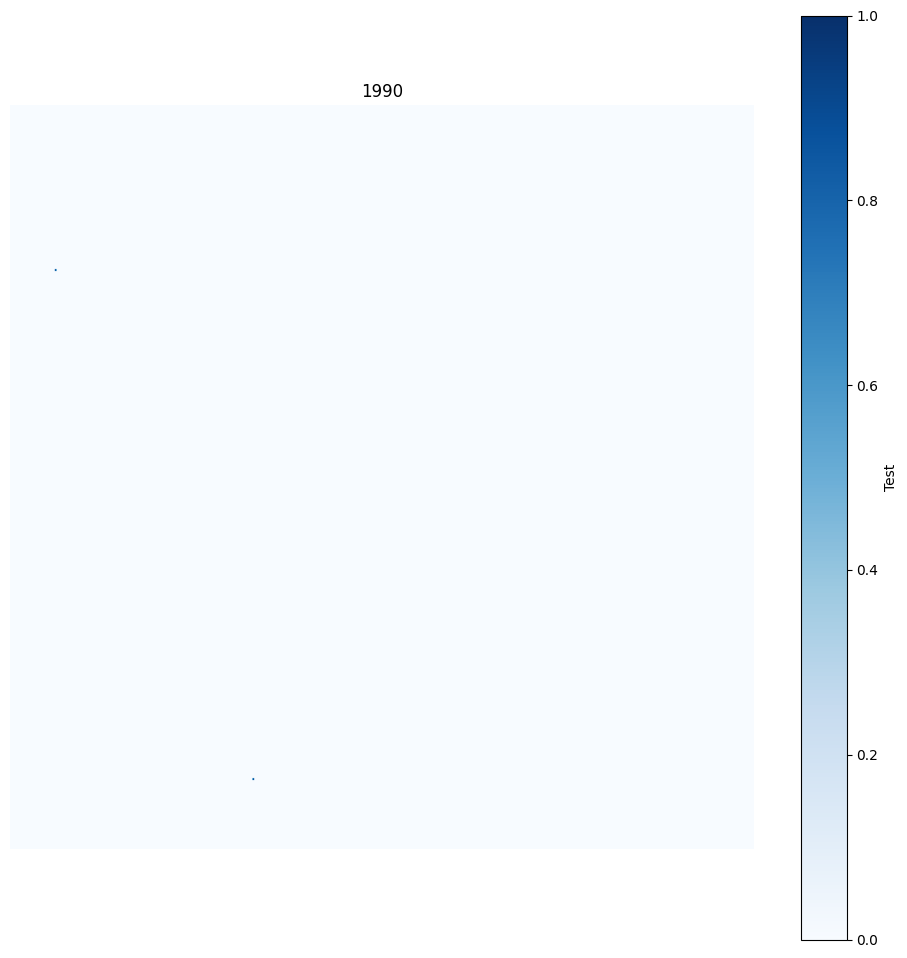

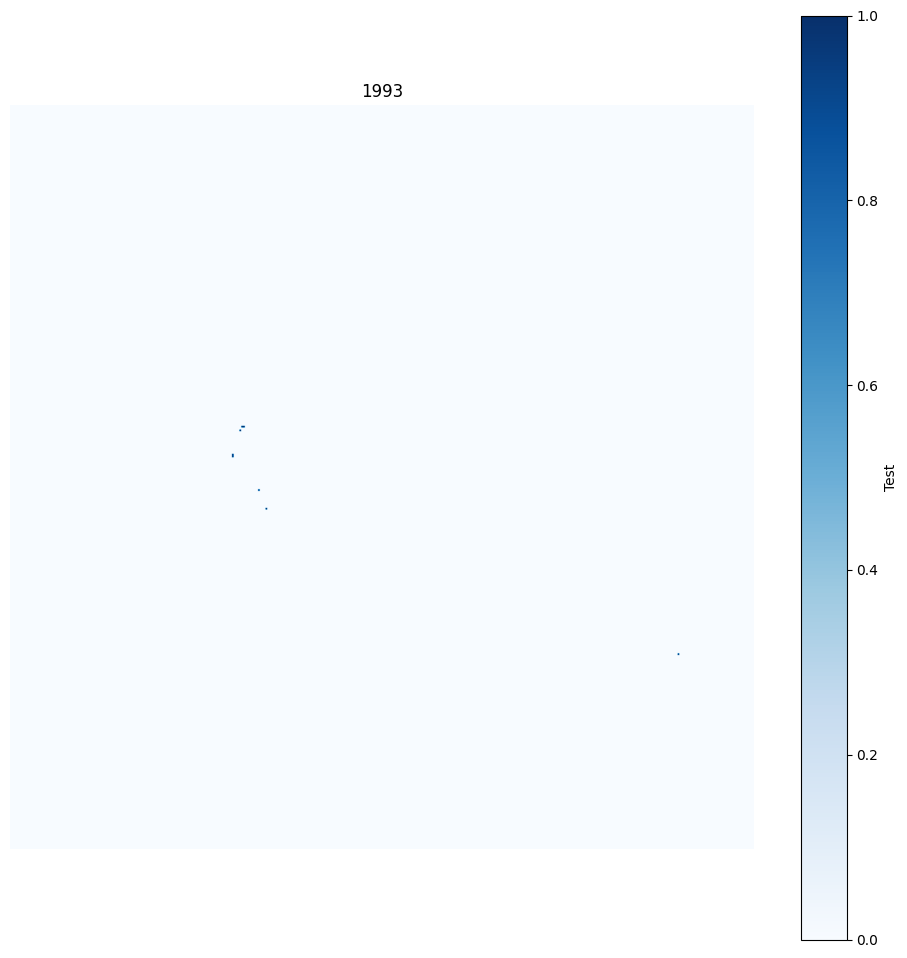

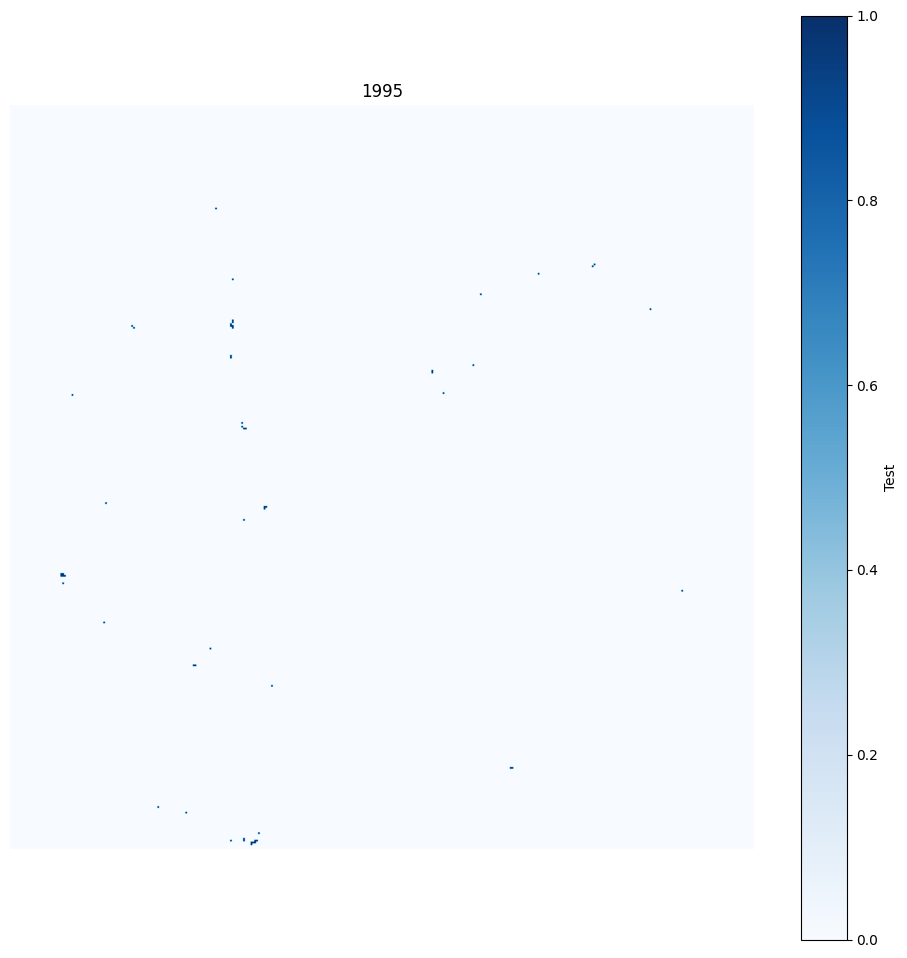

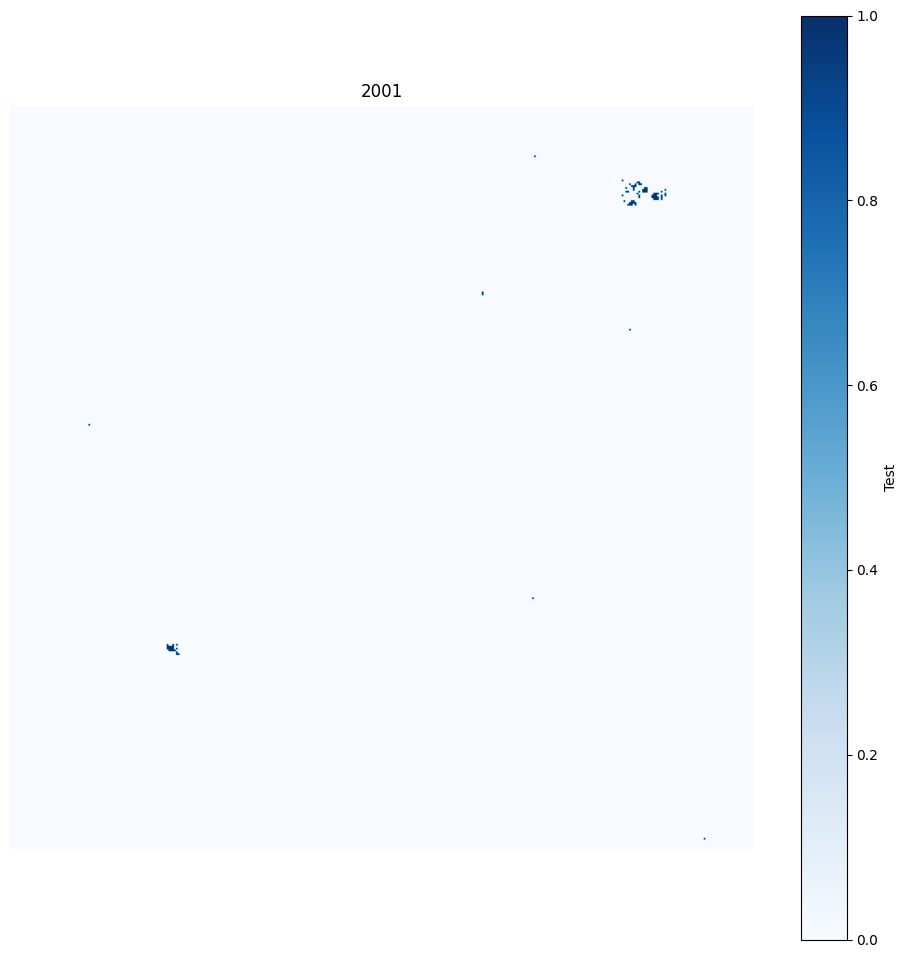

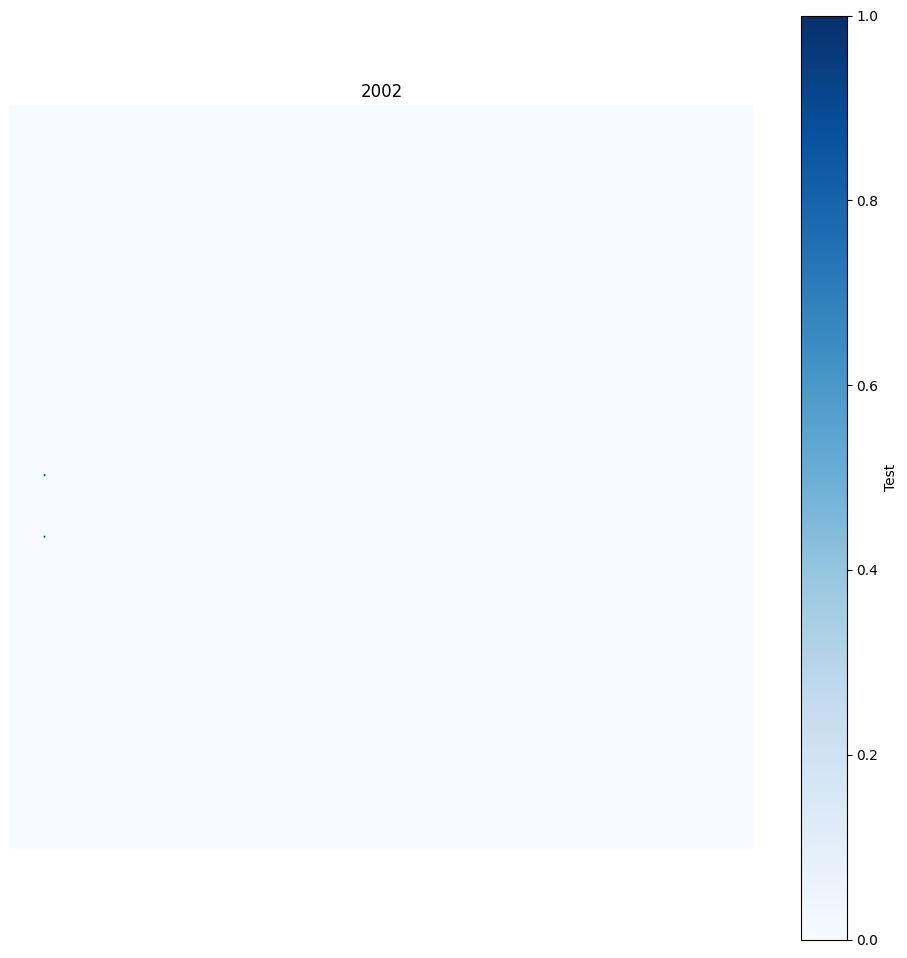

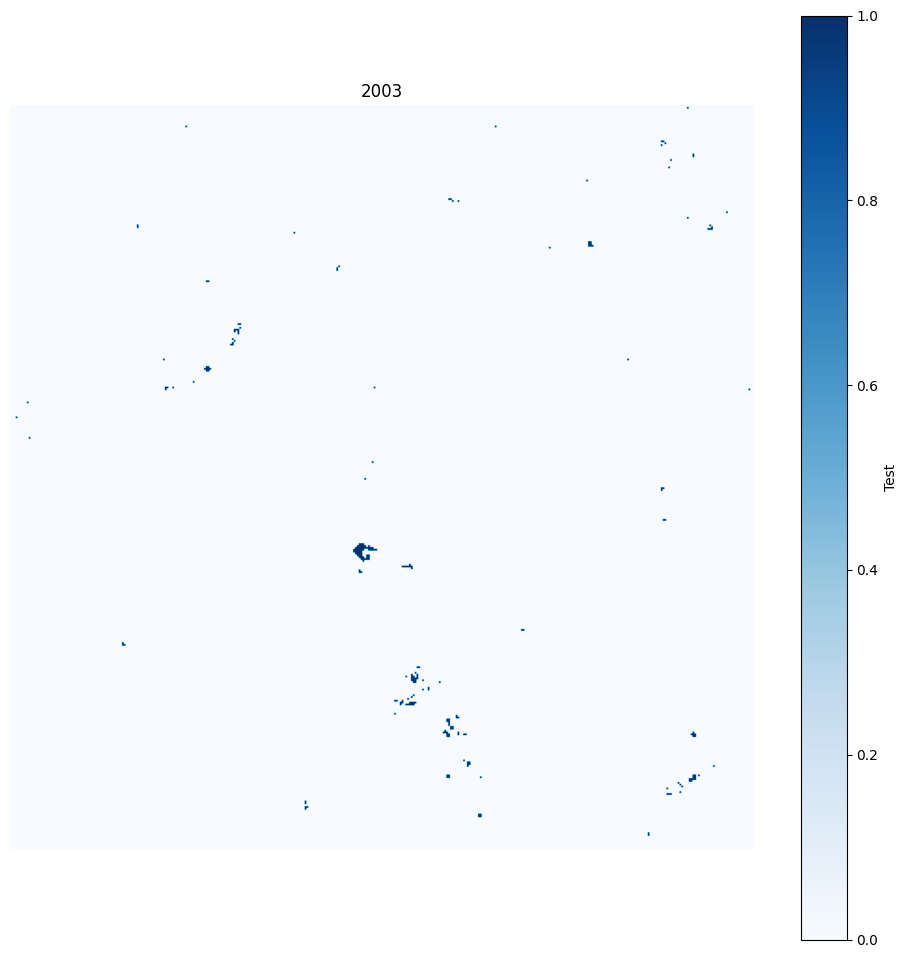

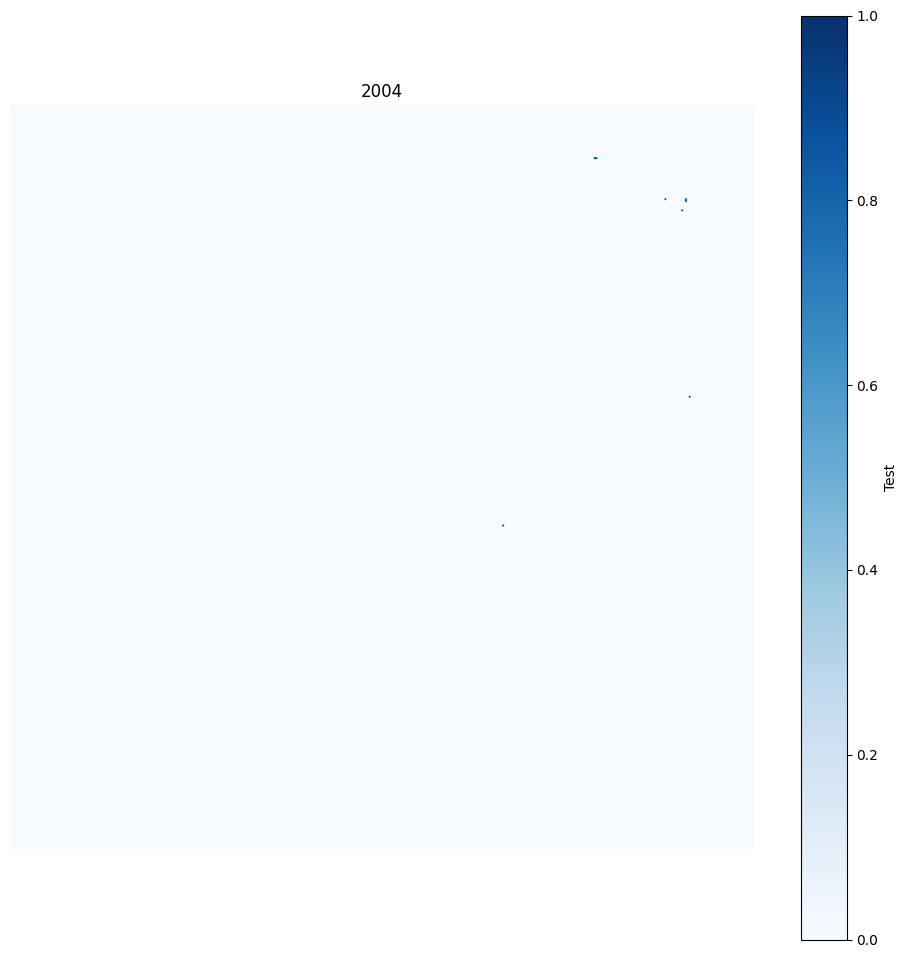

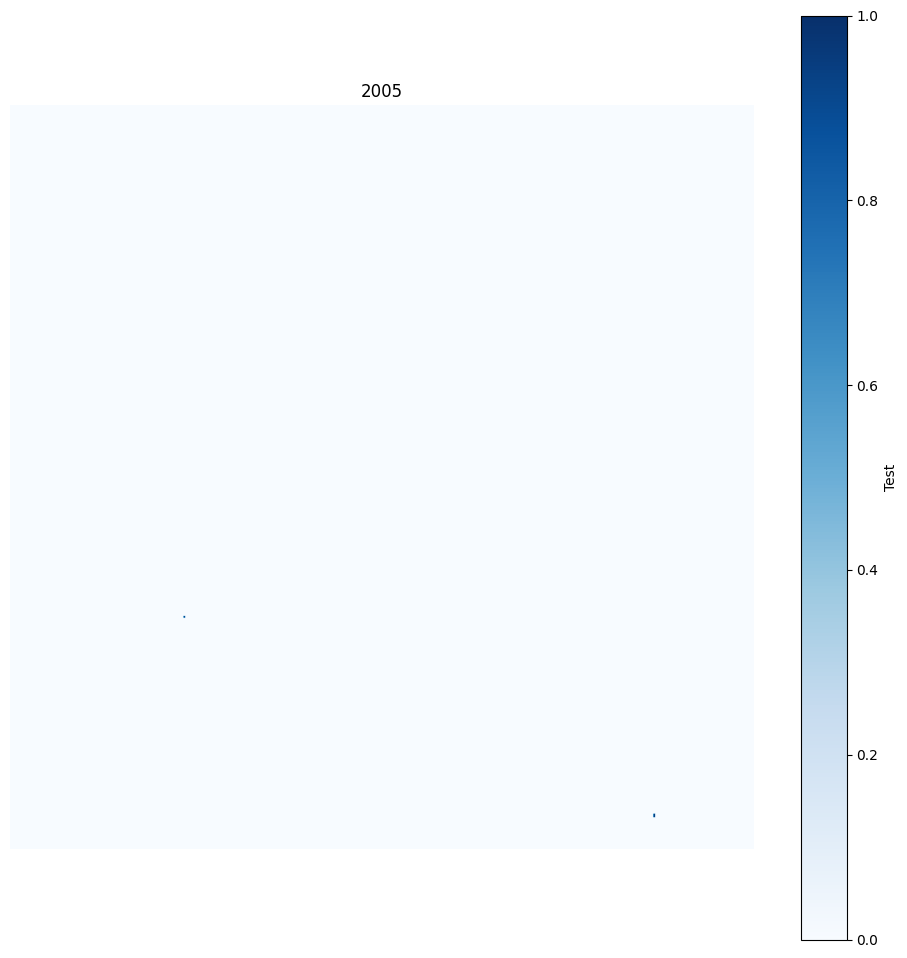

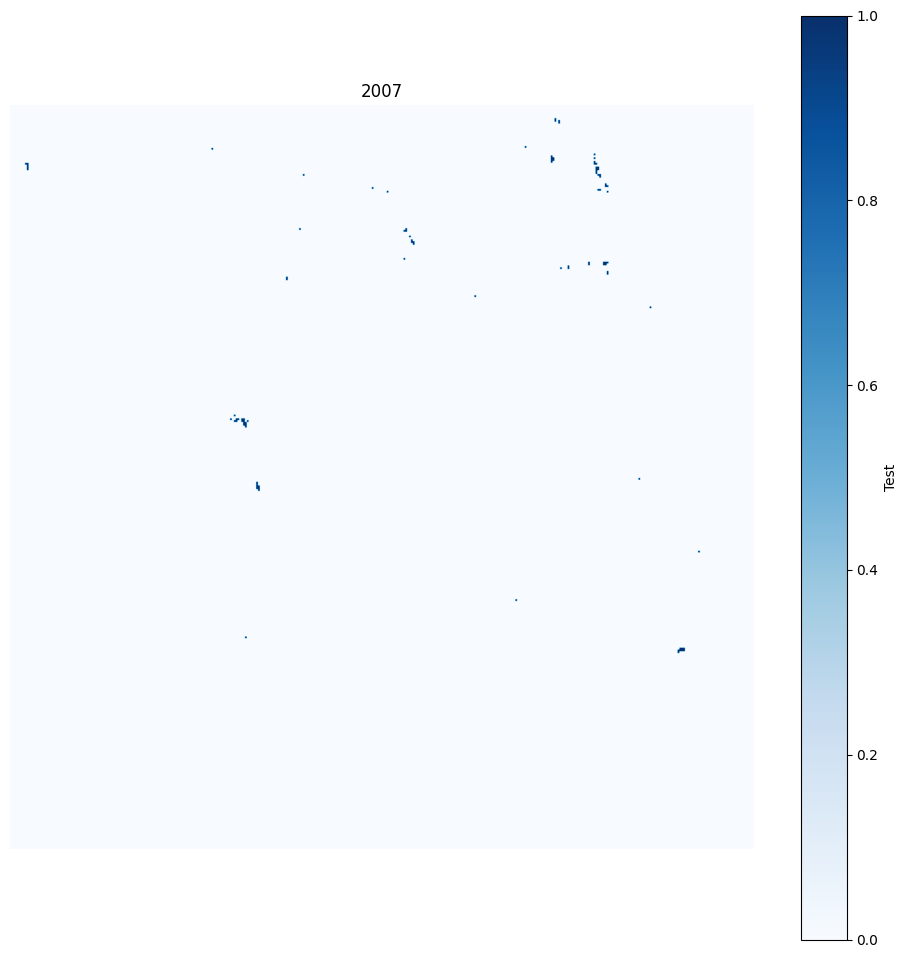

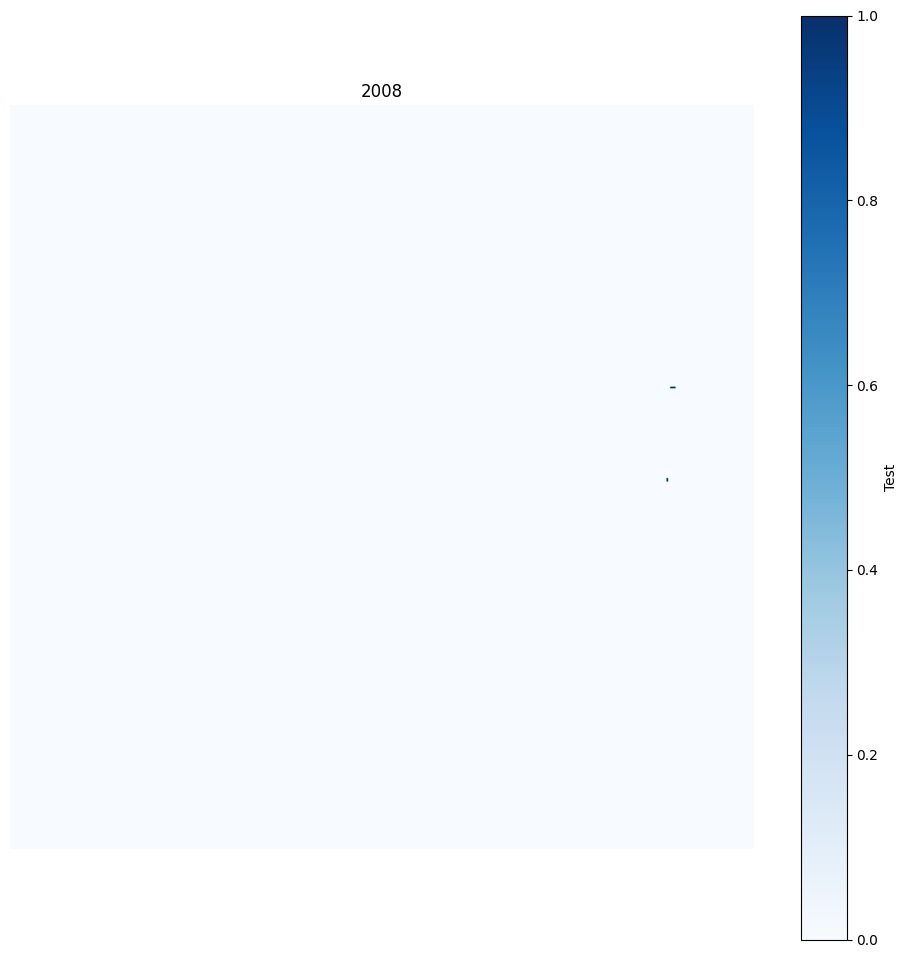

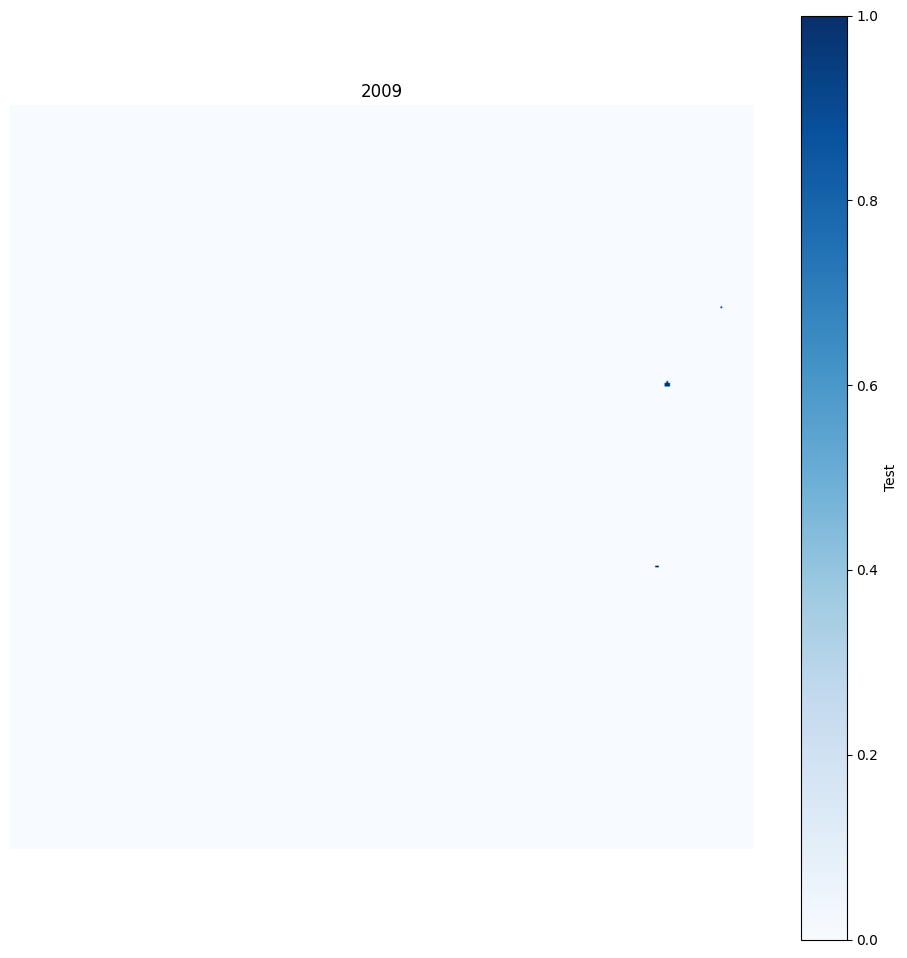

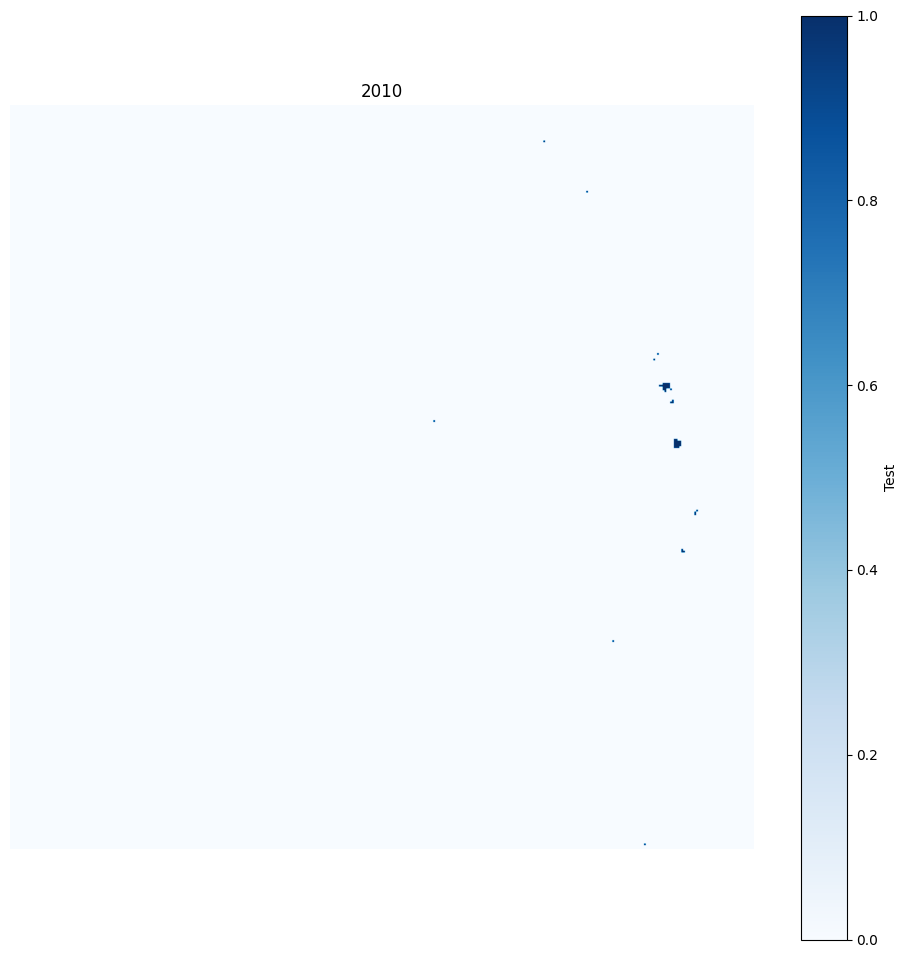

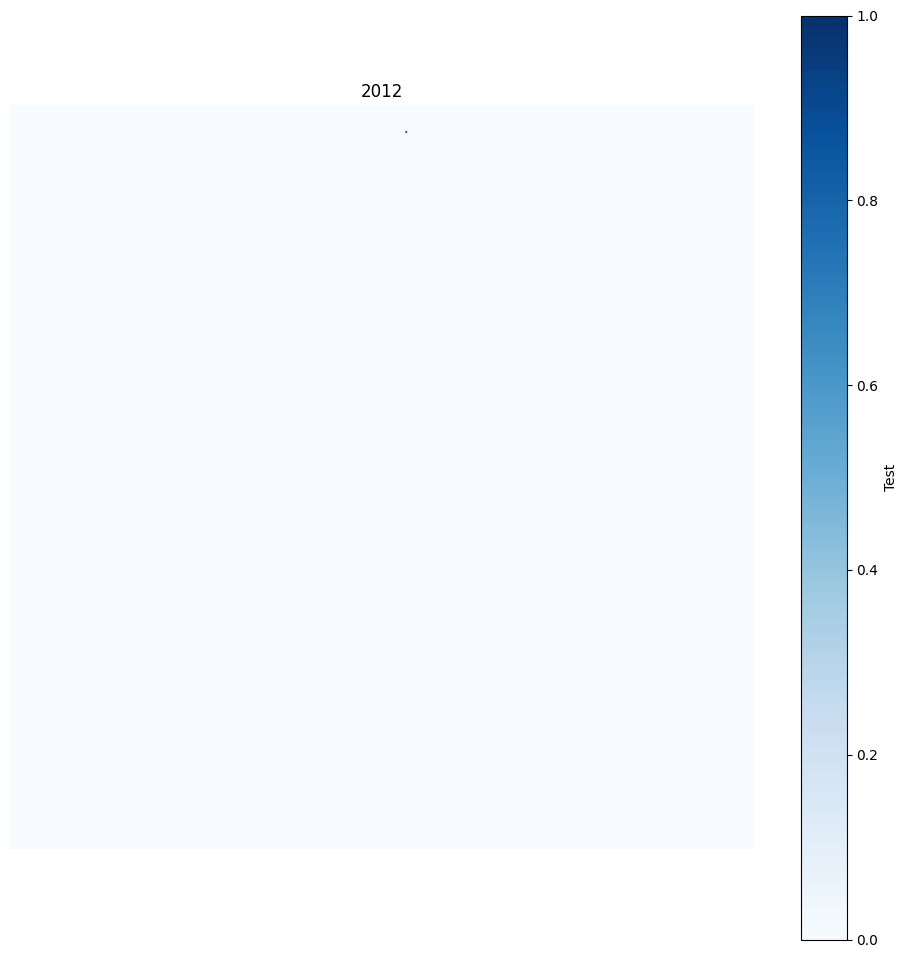

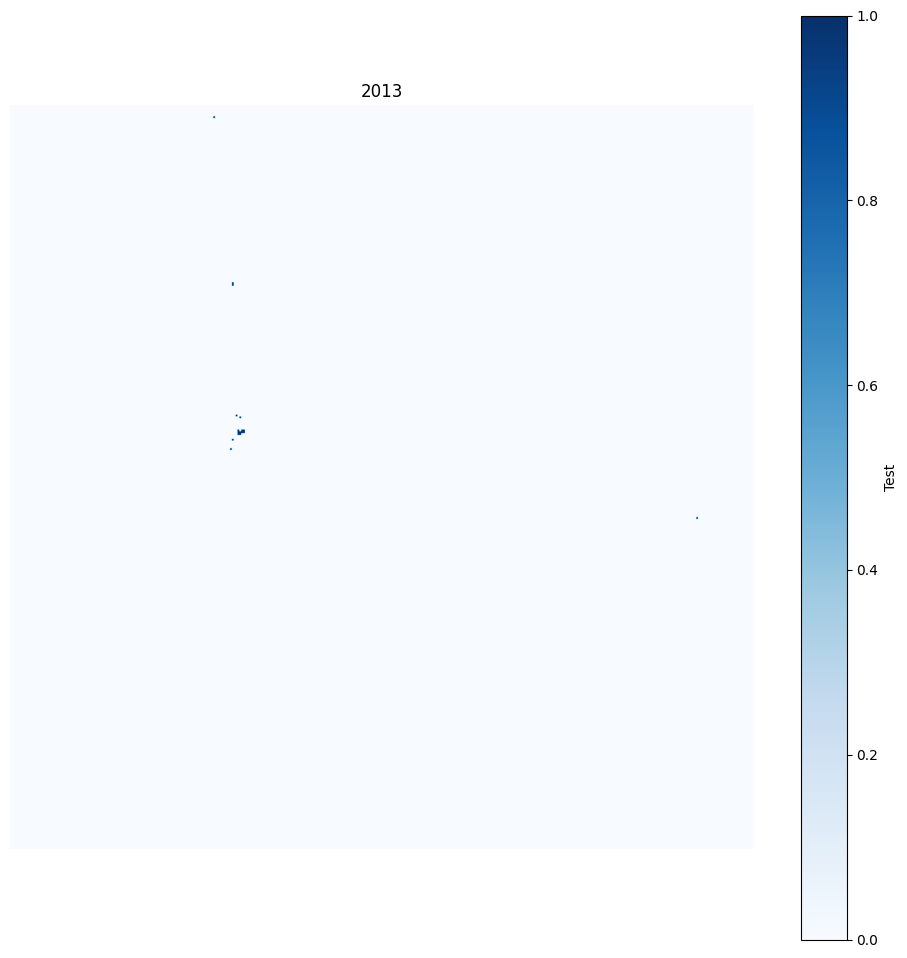

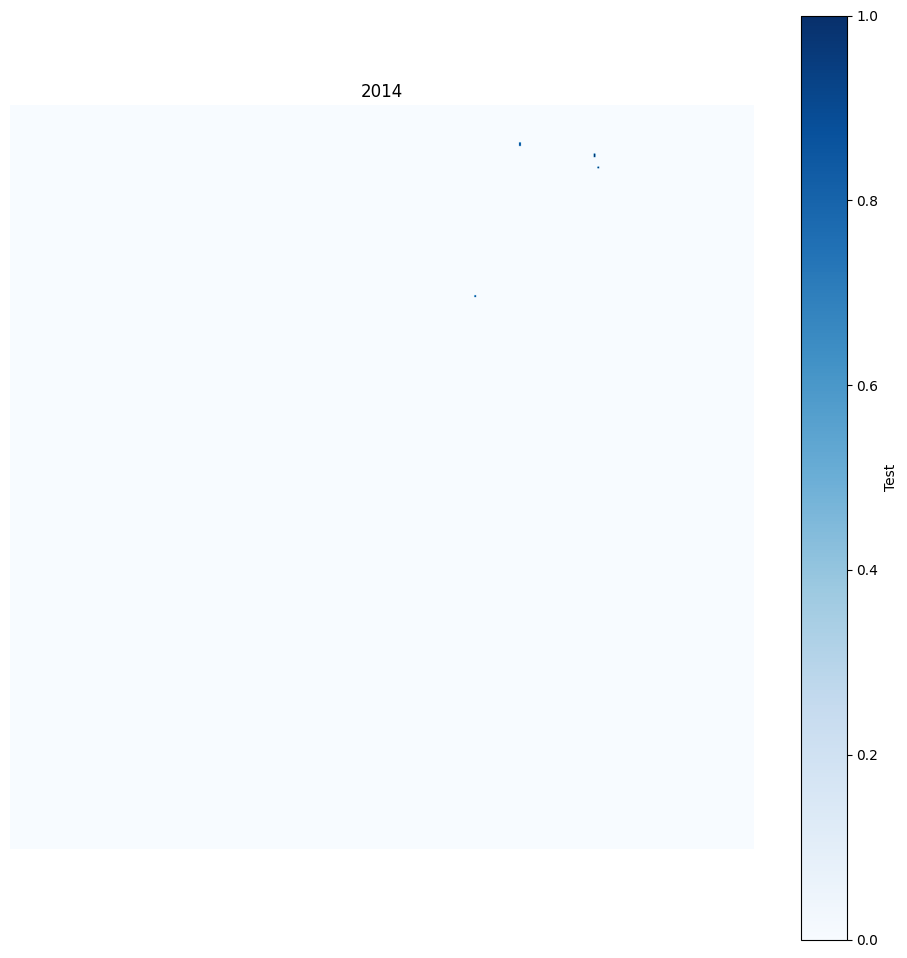

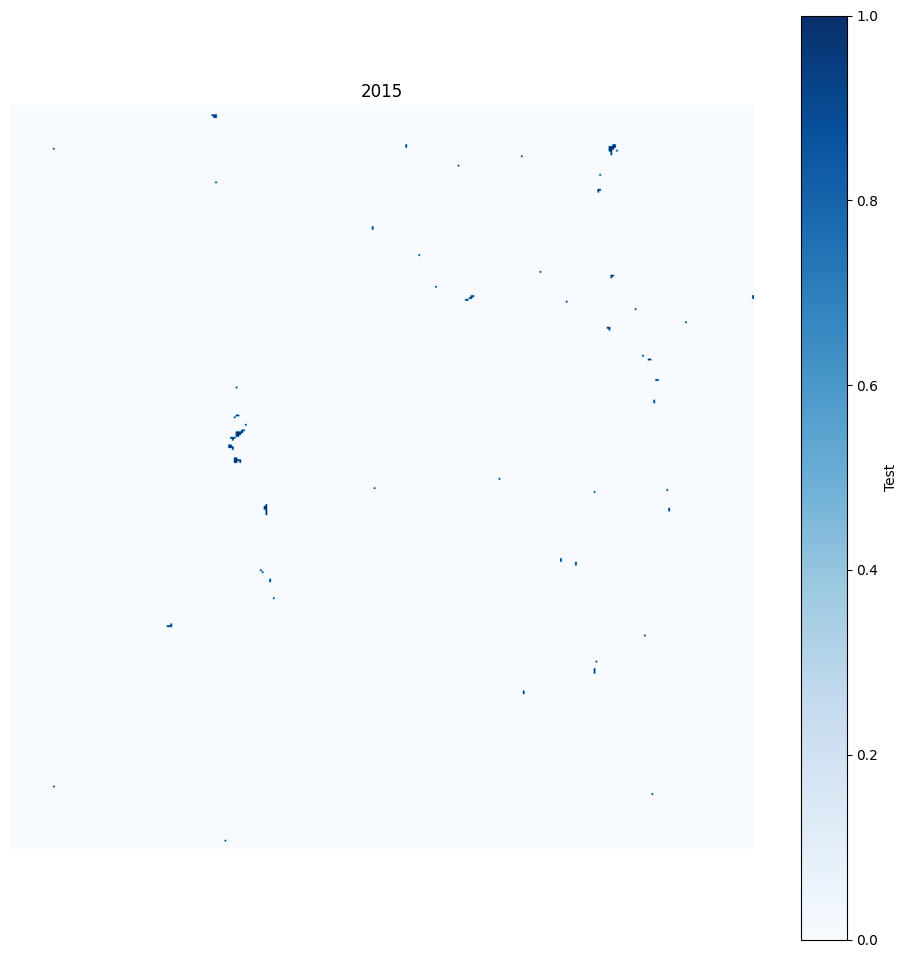

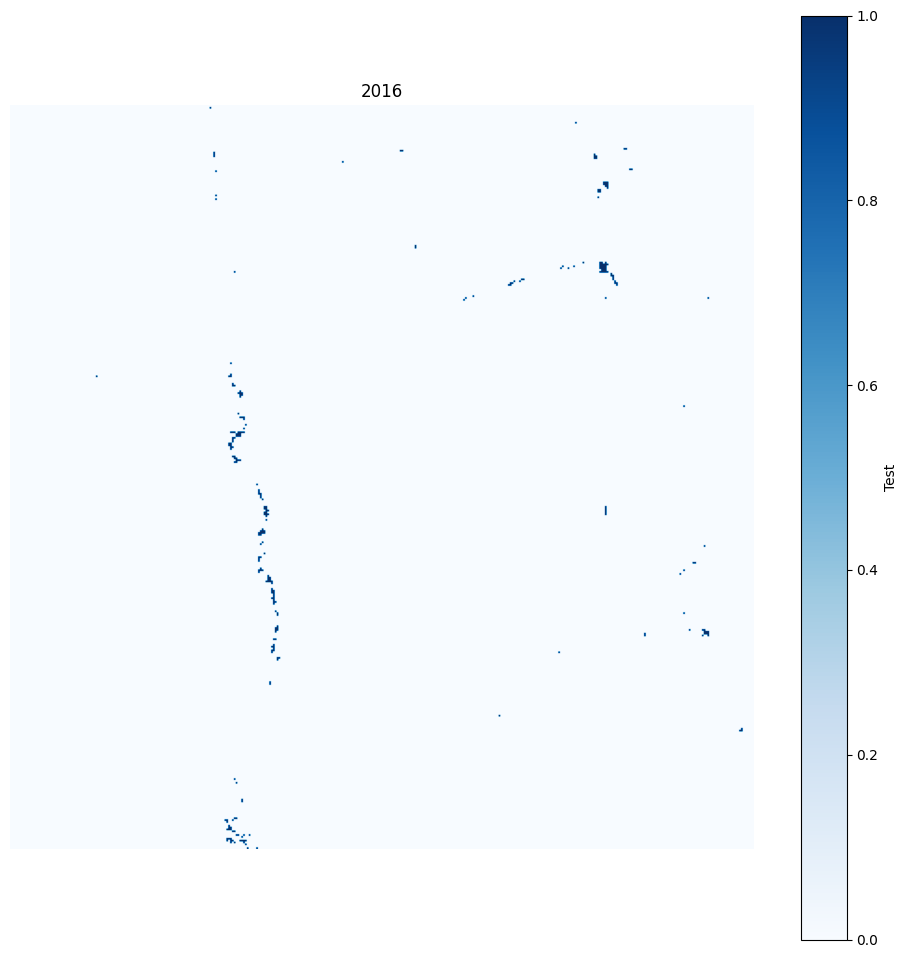

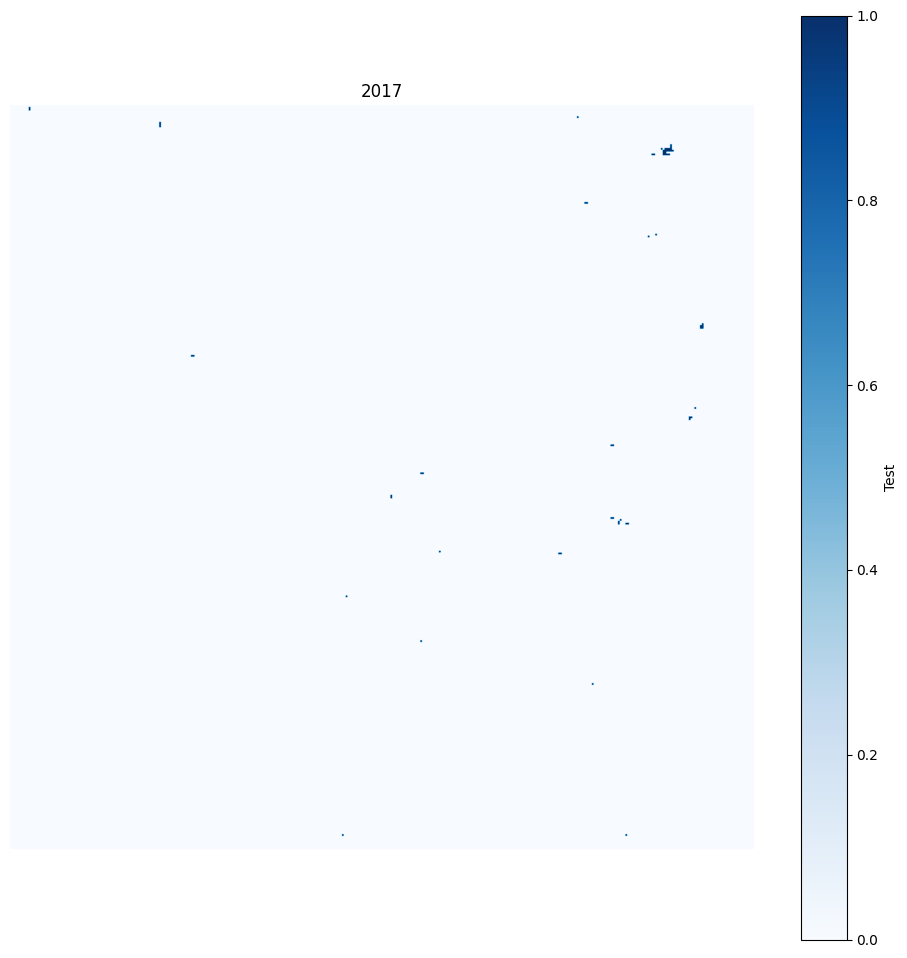

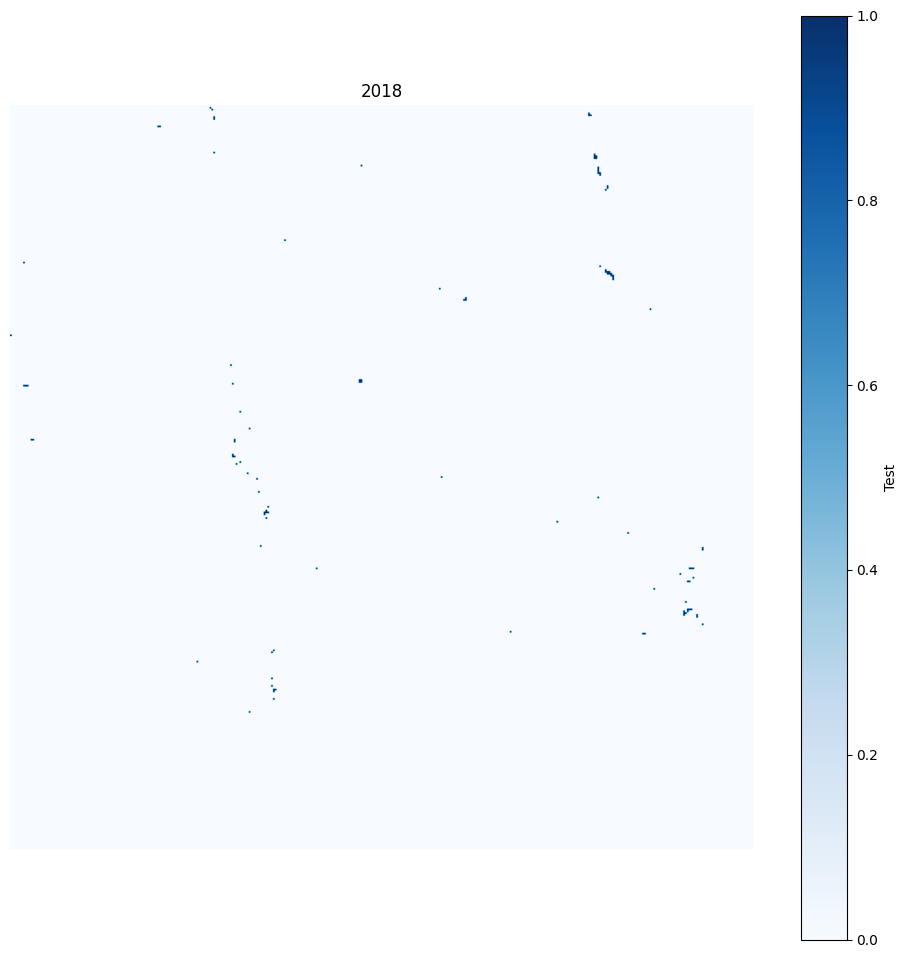

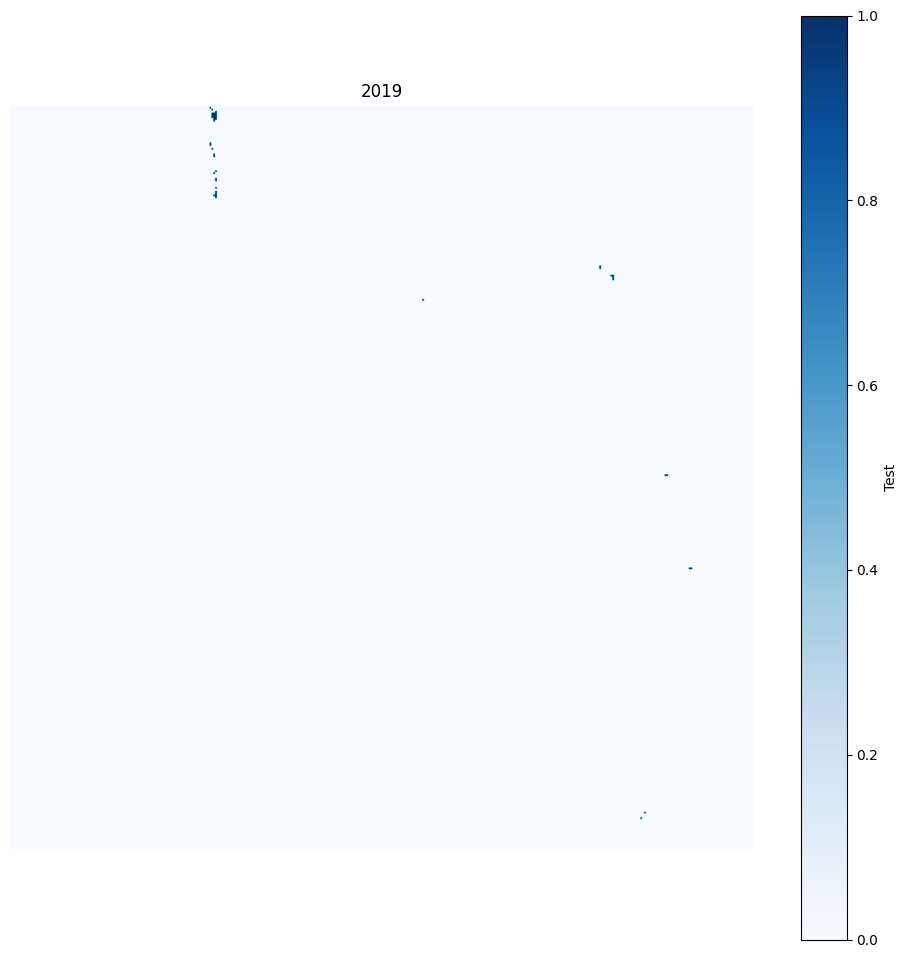

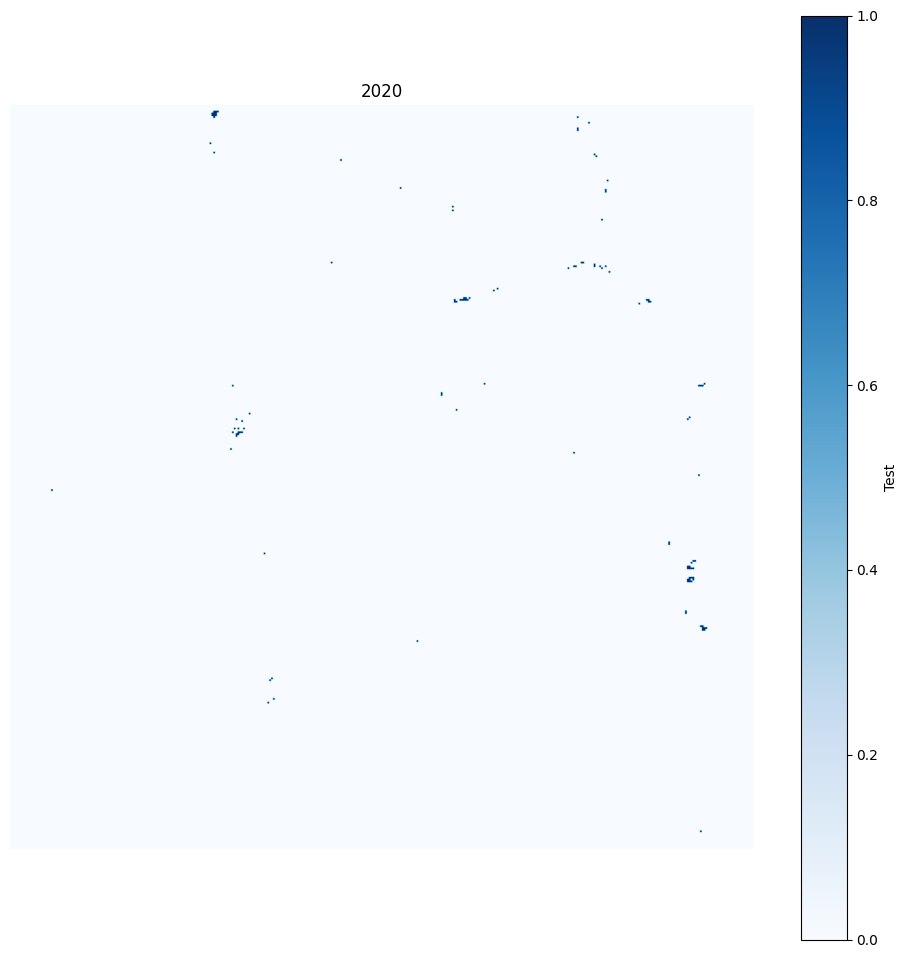

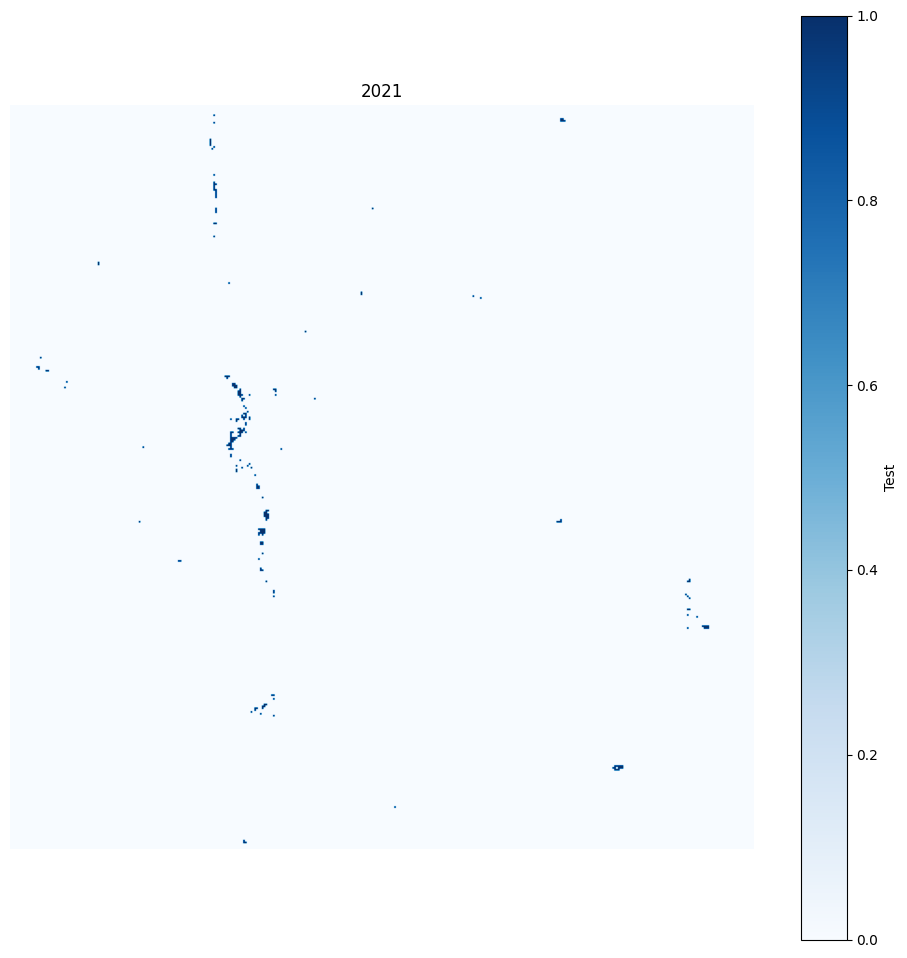

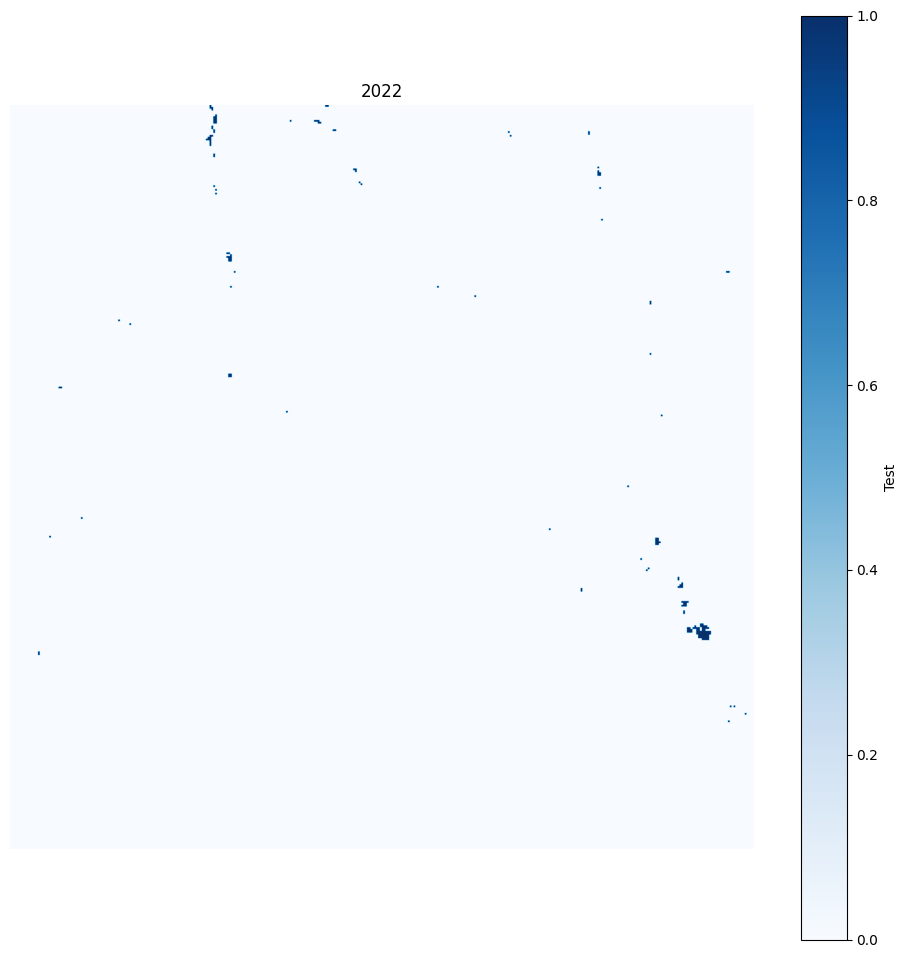

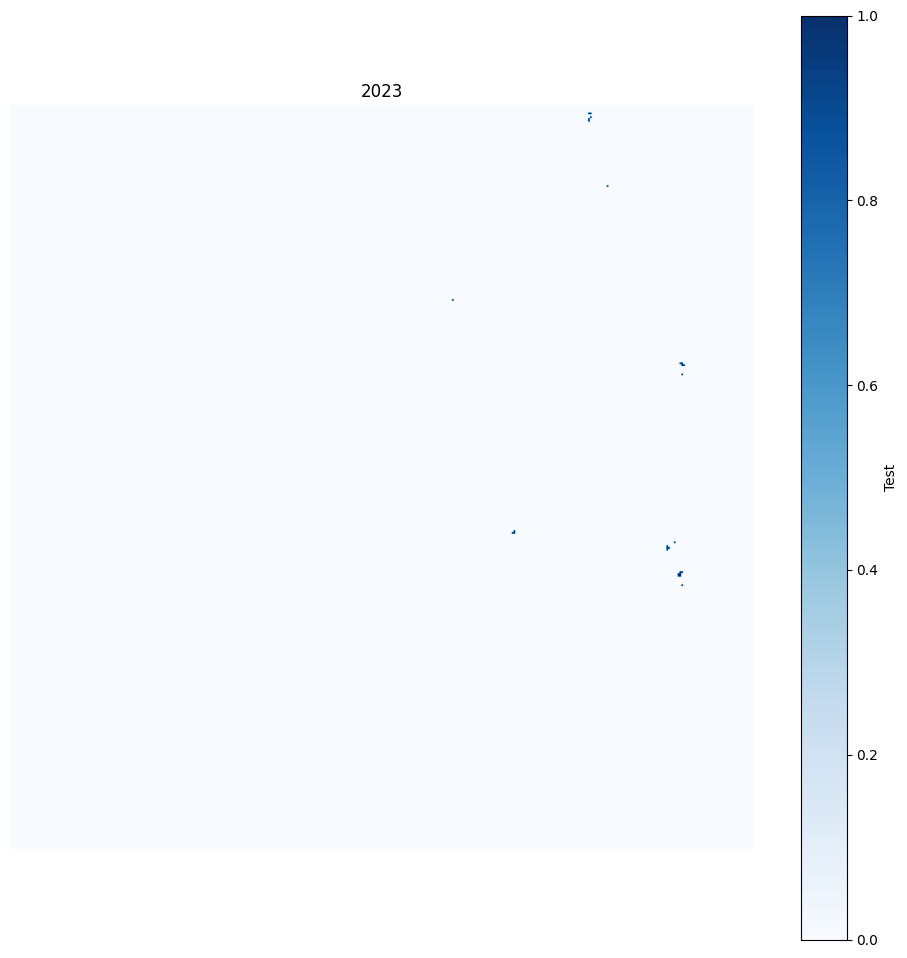

In [5]:
###################################
## MAKE TIFs ON EXTENSIVE MARGIN ##
###################################

test_files = os.listdir(f'D:/{path}_{row_name}_select_csv/')
sum_files = [file for file in test_files if file.endswith(f'{location}.csv')]
print(sum_files)
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
# for index, row in df_little.iterrows():
#     name = row['name']
#     type = row['type']
#     short = row['short']
#     for file_name in sum_files:
#         year2 = file_name[:4]
#         file_path = os.path.join(clean_path, file_name)
for file in sum_files:
    year2 = file[0:4]
    my_data = pd.read_csv(os.path.join(csv_folder, file))
    good = [5440, 21824, 5442, 21826, 5504, 21888, 5506, 21890, 5760, 22144, 7824, 24472, 24216, 8088]
    my_data['passable'] = np.where((my_data[f'qual_sow_{year2}'].isin(good)) & (my_data[f'qual_gro_{year2}'].isin(good)), 1, 0)
    my_data['indicator'] = np.where((my_data[f'evi_gro_{year2}'] >= my_data[f'evi_sow_{year2}'] + 1500) &
                                    (my_data['passable'] == 1) &
                                    (my_data[f'evi_sow_{year2}'] <= 2000), 1, 0)
    easting = my_data['easting']
    northing = my_data['northing']
    vector = my_data['indicator'] #fill in my_vector

    # Set up the raster properties
    pixel_size = 30
    x_min, x_max = easting.min(), easting.max()
    y_min, y_max = northing.min(), northing.max()

    cols = int((x_max - x_min) / pixel_size)
    rows = int((y_max - y_min) / pixel_size)

    # Create a raster
    transform = from_origin(x_min, y_max, pixel_size, pixel_size)
    raster = rasterio.open(f'{csv_folder}/{year2}_filter.tif', 'w', driver='GTiff', height=rows, width=cols, count=1, dtype='float32', crs='EPSG:4326', transform=transform)

    # Convert lon, lat, and vector data to a numpy array
    array = np.zeros((rows, cols), dtype=np.float32)

    for i in range(len(easting)):
        col = int((easting[i] - x_min) / pixel_size)
        row = int((y_max - northing[i]) / pixel_size)

        if 0 <= row < rows and 0 <= col < cols:
            array[row, col] = vector[i]

    raster.write(array, 1)
    raster.close()

    with rasterio.open(f'{csv_folder}/{year2}_filter.tif') as src: #same path as above
        # Read the raster data
        raster_data = src.read(1)
        raster_data = np.where(raster_data == src.nodata, 0, raster_data)
        min_value = np.nanmin(raster_data)
        max_value = np.nanmax(raster_data)
    plt.figure(figsize=(12, 12))
    plt.imshow(raster_data, cmap='Blues',vmin=0, vmax=1)
    plt.title(year2)
    plt.colorbar(label=f'Test')
    plt.axis('off')
    # plt.show()
    # Add legend and title
    # plt.text(1, 0.5, f'Min: {min_value}, Max: {max_value}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
    # plt.text(0.5, 1.05, 'Legend and Title', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    # Save the plot as a PNG
    plt.savefig(f'{csv_folder}/{year2}_2.png', bbox_inches='tight', pad_inches=0.1)
    print(f'done')


# files = os.listdir(csv_folder)
# for file in files:
#     df = pd.read_csv(file)
#     df['crop'] =

In [6]:
import imageio.v2 as imageio
# Filter only files with certain extensions (e.g., PNG, JPG, etc.)
test_files = os.listdir(f'D:/{path}_{row_name}_select_csv/')
#image_files = sorted([file for file in test_files if file.endswith('.png')])
image_files = sorted([file for file in test_files if file.endswith('_2.png')])
# Initialize a list to store images
images = []

# Read each image file and append to the list
for filename in image_files:
    filepath = os.path.join(csv_folder, filename)
    images.append(imageio.imread(filepath))

# Create a GIF from the list of images
gif_path = f'{csv_folder}/' \
           f'fallow_filter_2.gif'
imageio.mimsave(gif_path, images, duration = 1, fps = 1, loop = 0)

#imageio.mimwrite(gif_path, images, duration = 1, loop = 0)

print(f"GIF saved to: {gif_path}")

GIF saved to: D:/170_064_select_csv/fallow_filter_2.gif


In [84]:
import sys
print(sys.version)


3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]
